In [46]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%matplotlib inline
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [34]:
num_classes = 43
resize_image = (32, 32)

### Reading and Preprocessing of images

In [35]:
def read_data(classes):
    images = []
    labels = []
    
    for lbl in range(classes):
        full_path = os.path.join('GTSRB', 'Final_Training', 'Images') + '/' + format(lbl, '05d') + '/'
        
        print('reading folder: {}'.format(full_path))
        
        for img in glob.glob(full_path + '*.ppm'):
            
            image = plt.imread(img)
            image = resize(image, resize_image, mode = 'reflect')
            image = image.astype(np.float32)
            
            label = np.zeros((classes, ), dtype = np.float32)
            label[lbl] = 1.0
            
            images.append(image)
            labels.append(label)
            
    return images, labels

In [36]:

X, y = read_data(num_classes)

reading folder: GTSRB/Final_Training/Images/00000/


/home/monu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


reading folder: GTSRB/Final_Training/Images/00001/
reading folder: GTSRB/Final_Training/Images/00002/
reading folder: GTSRB/Final_Training/Images/00003/
reading folder: GTSRB/Final_Training/Images/00004/
reading folder: GTSRB/Final_Training/Images/00005/
reading folder: GTSRB/Final_Training/Images/00006/
reading folder: GTSRB/Final_Training/Images/00007/
reading folder: GTSRB/Final_Training/Images/00008/
reading folder: GTSRB/Final_Training/Images/00009/
reading folder: GTSRB/Final_Training/Images/00010/
reading folder: GTSRB/Final_Training/Images/00011/
reading folder: GTSRB/Final_Training/Images/00012/
reading folder: GTSRB/Final_Training/Images/00013/
reading folder: GTSRB/Final_Training/Images/00014/
reading folder: GTSRB/Final_Training/Images/00015/
reading folder: GTSRB/Final_Training/Images/00016/
reading folder: GTSRB/Final_Training/Images/00017/
reading folder: GTSRB/Final_Training/Images/00018/
reading folder: GTSRB/Final_Training/Images/00019/
reading folder: GTSRB/Final_Tra

In [42]:
X = np.asarray(X)
print('X shape:', X.shape)

y = np.asarray(y)
print('y shape:', y.shape)

X shape: (39209, 32, 32, 3)
y shape: (39209, 43)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


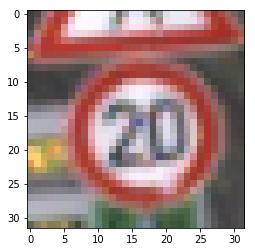

In [43]:
plt.imshow(X[0,:,:,:])
print(y[0, :])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


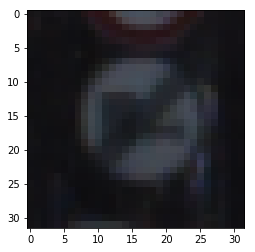

In [44]:
plt.imshow(X[-1,:,:,:])
print(y[-1, :])

### Splitting into train and test set

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [48]:
print('X train shape:', X_train.shape)
print('X test shape:', X_test.shape)

print('y train shape:', y_train.shape)
print('y test shape:', y_test.shape)

X train shape: (26270, 32, 32, 3)
X test shape: (12939, 32, 32, 3)
y train shape: (26270, 43)
y test shape: (12939, 43)


### Batch Generator

In [58]:
def batch_gen(data, labels, batch_size):
    
    for batch_num in range(data.shape[0] // batch_size):
        
        batch_data = data[batch_num * batch_size : batch_num * batch_size + batch_size]
        batch_labels = labels[batch_num * batch_size : batch_num * batch_size + batch_size]
    
        yield batch_data, batch_labels

In [63]:
for batch in batch_gen(X_train, y_train, 5000):
    print(batch[0].shape, batch[1].shape)

(5000, 32, 32, 3) (5000, 43)
(5000, 32, 32, 3) (5000, 43)
(5000, 32, 32, 3) (5000, 43)
(5000, 32, 32, 3) (5000, 43)
(5000, 32, 32, 3) (5000, 43)


### Conv layer

In [79]:
def conv_layer(in_tensors, kernel_size, output_depth):
    
    w = tf.get_variable('conv_w', [kernel_size, kernel_size, in_tensors.get_shape()[3], output_depth], tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('conv_b', [output_depth, ], tf.float32, tf.constant_initializer(0.0))
    return tf.nn.relu(tf.nn.conv2d(in_tensors, w, [1,1,1,1], 'SAME') + b)

### Maxpool layer

In [66]:
def maxpool_layer(in_tensors, kernel_size):
    return tf.nn.max_pool(in_tensors, [1, kernel_size, kernel_size, 1], [1,1,1,1], 'SAME')

### Dropout layer

In [67]:
def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)

### FC layer without activation

In [81]:
def fc_without_activation_layer(in_tensors, n_units):
    
    w = tf.get_variable('fc_w', [in_tensors.get_shape()[1], n_units], tf.float32, tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('fc_b', [n_units, ], tf.float32, tf.constant_initializer(0.0))
    
    return tf.matmul(in_tensors, w) + b

### FC layer with activation

In [70]:
def fc_layer(in_tensors, n_units):
    return tf.nn.relu(fc_without_activation_layer(in_tensors, n_units))

In [83]:
def model(in_tensors, is_training):
    
    with tf.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 3, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
        
    with tf.variable_scope('l2'):
        l2 = maxpool_layer(conv_layer(l1_out, 3, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
        
    with tf.variable_scope('flatten'):
        l2_out_flat = tf.layers.flatten(l2_out)
        
    with tf.variable_scope('l3'):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)
        
    with tf.variable_scope('out'):
        out_tensors = fc_without_activation_layer(l3_out, num_classes)
        
    return out_tensors

In [89]:
def train_model(X_train, y_train, X_test, y_test, learning_rate, num_epochs, batch_size):
    
    X_batch = tf.placeholder(tf.float32, shape = (None, resize_image[0], resize_image[1], 3))
    y_batch = tf.placeholder(tf.float32, shape = (None, num_classes))
    is_training = tf.placeholder(tf.bool)
    
    logits = model(X_batch, is_training)
    
    out_y_pred = tf.nn.softmax(logits)
    
    loss_score = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_batch)
    loss = tf.reduce_mean(loss_score)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(num_epochs):
            print('epoch = ', epoch)
            train_loss = []
            for batch in batch_gen(X_train, y_train, batch_size):
                feed_dict = {X_batch: batch[0], y_batch: batch[1], is_training: True}
                _, tf_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
                train_loss.append(tf_loss)
            print('train loss:', np.mean(train_loss))
            
        print('TEST SET PERFORMANCE')
        y_test_pred, test_loss = sess.run([out_y_pred, loss], feed_dict = {X_batch: X_test, y_batch: y_test, is_training: False})
        
        print('test loss:', test_loss)
        
        y_test_pred_classified = np.argmax(y_test_pred, axis = 1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis = 1).astype(np.int32)
        
        print('test score:', np.mean(y_test_pred_classified == y_test_true_classified) * 100)
        

In [ ]:
tf.reset_default_graph()

train_model(X_train, y_train, X_test, y_test, 0.001, 10, 128)

epoch =  0
train loss: 1.8987176
epoch =  1
train loss: 0.33006063
epoch =  2
train loss: 0.16065103
epoch =  3
train loss: 0.09959687
epoch =  4
train loss: 0.07806328
epoch =  5
train loss: 0.06083268
epoch =  6
train loss: 0.04405927
epoch =  7
train loss: 0.04438391
epoch =  8
train loss: 0.033261865
epoch =  9
train loss: 0.028436275
TEST SET PERFORMANCE
